# Convolutional Autoencoder

The model is made using Keras Function API and makes a Autoencoder model from scratch and also loads a pre-trained model if it's available in the current directory. 
Random seed is implemented for regenration of results. This repository also contains the Accuracy and Loss graphs for both auto-encoder and prediction model. 

The noise is added to the model and saved in a variable 'x_test_noisy'.
The predictor model loads the weights from the encoder part of the auto-encoder model and then fine-tunes the last dense layer. The model gives an accuracy of 84.42% on noise images. I have tested some of the images randomly and used matplotlib to desplay the re-construction of the model and the prediction.

In [1]:
from keras.layers import Dense, Conv2D, Flatten, Reshape, Conv2DTranspose, Input
from keras.models import Sequential, Model, load_model
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from matplotlib import pyplot as plt
from keras.optimizers import Adam
from keras.datasets import mnist
import numpy as np
import random
import os

np.random.seed(1337)

Using TensorFlow backend.


In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()
X_train = X_train/255.0
X_test = X_test/255.0
X_train = np.expand_dims(X_train, axis=-1)
X_test = np.expand_dims(X_test, axis=-1)

In [3]:
X_train.shape

(60000, 28, 28, 1)

In [4]:
X_test.shape

(10000, 28, 28, 1)

In [5]:
flag = 0
if os.path.isfile('autoencoder-5-epochs.h5'):
    flag = 1
    print('Pre-trained model loaded')
    autoencoder = load_model('autoencoder-5-epochs.h5')
    print(autoencoder.summary())
else:
    encoder_input = Input(shape=(28,28,1))
    encode = Conv2D(32, (3,3), activation='relu')(encoder_input)
    encode = Conv2D(32, (3,3), activation='relu')(encode)
    encode = Conv2D(32, (5,5), activation='relu')(encode)
    encode = Conv2D(64, (7,7), activation='relu')(encode)
    encode = Conv2D(64, (9,9), activation='relu')(encode)
    encode = Flatten()(encode)
    encode = Dense(512, activation='relu')(encode)
    encode = Dense(128, activation='sigmoid')(encode)
    decoder = Dense(512, activation='relu', input_shape=(128,))(encode)
    decoder = Dense(1024, activation='relu')(decoder)
    decoder = Reshape((8,8,-1))(decoder)
    decoder = Conv2DTranspose(64, (9,9), activation='relu')(decoder)
    decoder = Conv2DTranspose(64, (7,7), activation='relu')(decoder)
    decoder = Conv2DTranspose(32, (5,5), activation='relu')(decoder)
    decoder = Conv2DTranspose(1, (3,3), activation='relu')(decoder)

    encoder = Model(inputs = encoder_input, outputs = encode)
    autoencoder = Model(inputs = encoder_input, outputs = decoder)
    print(autoencoder.summary())
    autoencoder.compile(optimizer=Adam(), loss='mse', metrics=['accuracy'])
    
    history = autoencoder.fit(x=X_train, y=X_train, validation_split=0.1, epochs=5, batch_size=32)
    autoencoder.save('autoencoder-5-epochs.h5')

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        100416    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0   

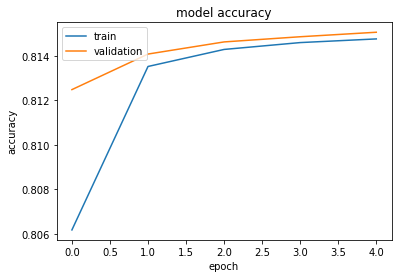

In [6]:
if flag == 0:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Accuracy-AutoEncoder.png')
    plt.show()

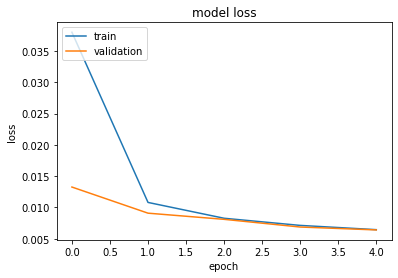

In [7]:
if flag == 0:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Loss-AutoEncoder.png')
    plt.show()

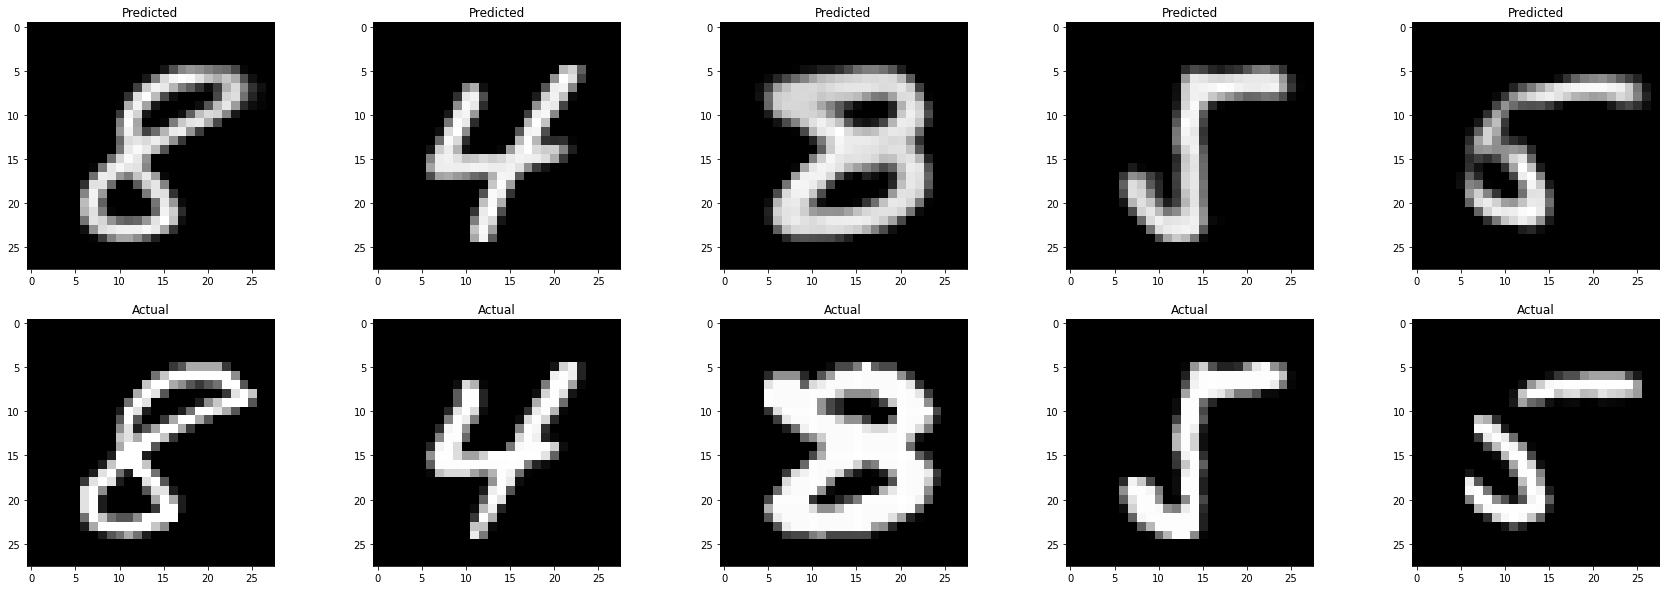

In [8]:
# Training Images
fig, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,5):
    index = random.randint(0,10000)
    ax[0,i].imshow(autoencoder.predict(np.expand_dims(X_test[index], axis=0))[0,:,:,0], cmap='gray')
    ax[0,i].set_title('Predicted')
    ax[1,i].imshow(X_test[index][:,:,0], cmap='gray')
    ax[1,i].set_title('Actual')
plt.show()

In [9]:
x_test_noisy = X_test + 0.2 * np.random.normal(loc=0.0, scale=1.0, size=X_test.shape) 

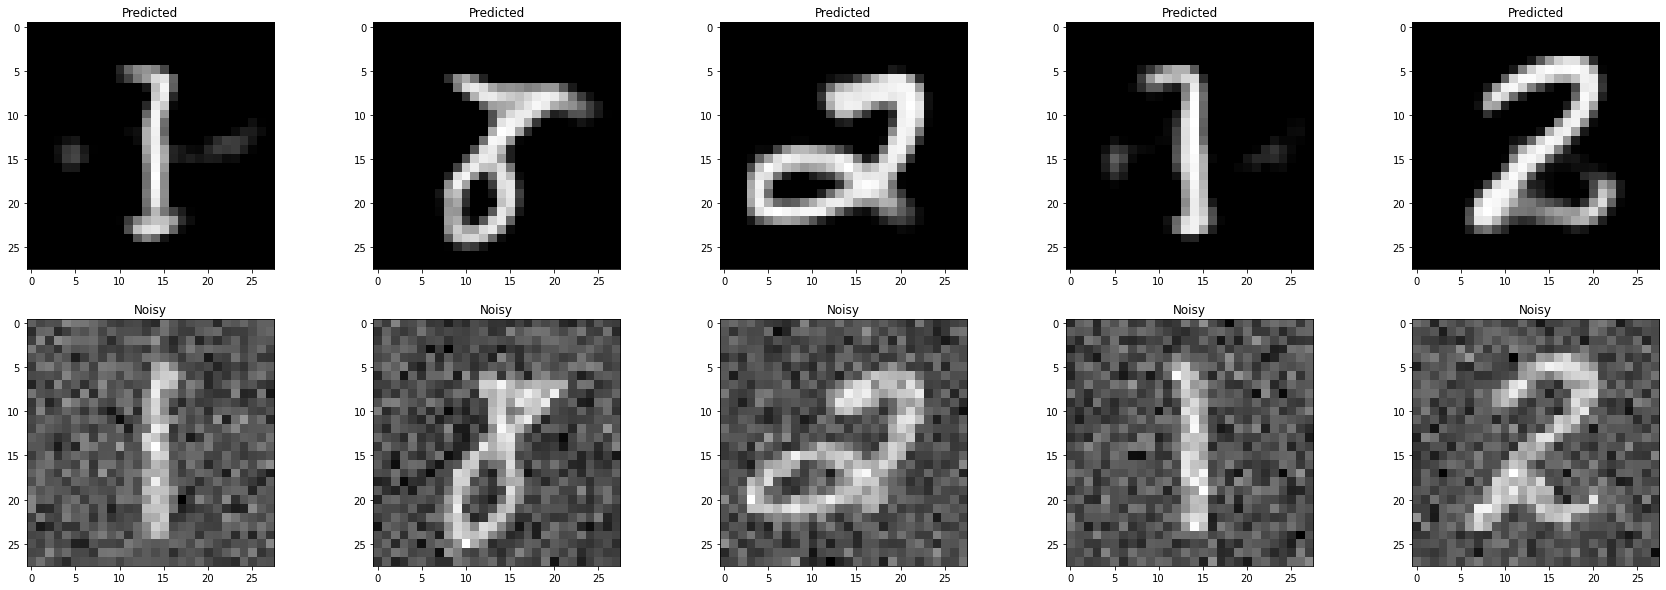

In [10]:
fig, ax = plt.subplots(2,5, figsize=(30,10))
for i in range(0,5):
    index = random.randint(0,10000)
    ax[0,i].imshow(autoencoder.predict(np.expand_dims(x_test_noisy[index], axis=0))[0,:,:,0], cmap='gray')
    ax[0,i].set_title('Predicted')
    ax[1,i].imshow(x_test_noisy[index][:,:,0], cmap='gray')
    ax[1,i].set_title('Noisy')
plt.show()

In [11]:
flag = 0
if os.path.isfile('predictor.h5'):
    flag = 1
    predictor = load_model('predictor.h5')
else:
    predictor = Sequential(autoencoder.layers[:9])
    predictor.add(Dense(10, activation='softmax',name='Predictor_Dense'))
    for l1,l2 in zip(predictor.layers[:9], autoencoder.layers[1:9]):
        l1.set_weights(l2.get_weights())
    for layer in predictor.layers[:-1]:
        layer.trainable = False
    predictor.summary()
    predictor.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    y_train = to_categorical(y_train, num_classes=10)
    history = predictor.fit(X_train, y_train, batch_size=32, epochs=15, validation_split=0.1)
    predictor.save('predictor.h5')

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 32)        9248      
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 20, 20, 32)        25632     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        100416    
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 6, 6, 64)          331840    
_________________________________________________________________
flatten_1 (Flatten)          (None, 2304)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)              

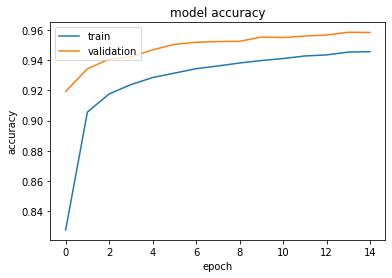

In [12]:
if flag == 0:
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Accuracy.png')
    plt.show()


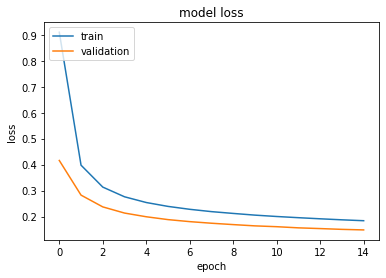

In [13]:
if flag == 0:
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.savefig('Loss.png')
    plt.show()

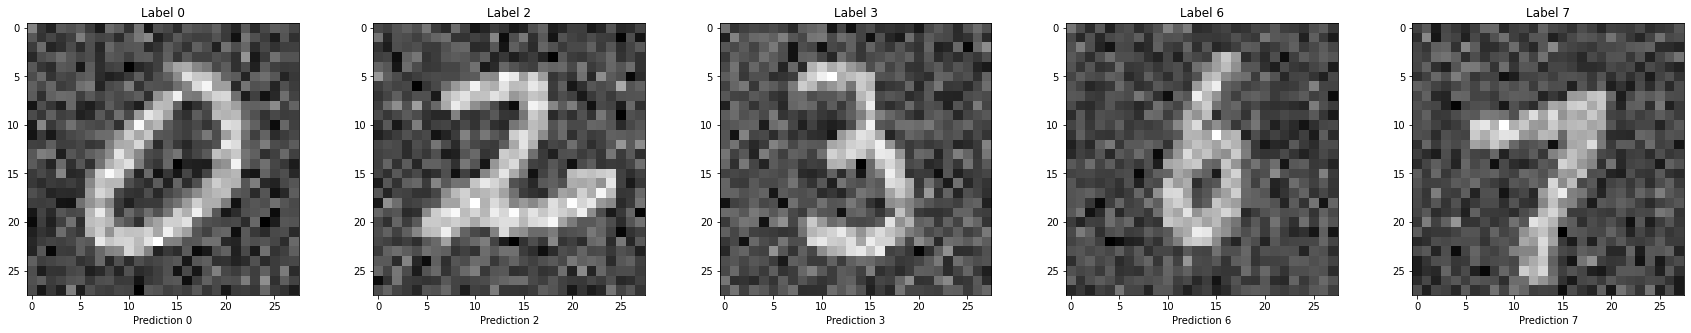

In [18]:
fig, ax = plt.subplots(1,5, figsize=(30,5))
for i in range(0,5):
    index = random.randint(0,10000)
    ax[i].set_title('Label {}'.format(y_test[index]))
    ax[i].imshow(x_test_noisy[index,:,:,0], cmap='gray')
    ax[i].set_xlabel('Prediction {}'.format(np.argmax(predictor.predict(np.expand_dims(x_test_noisy[index], axis=0)))))
plt.show()

In [15]:
predictions = predictor.predict(x_test_noisy)

In [16]:
def get_accuracy(predictions, y):
    return sum(np.argmax(predictions, axis=1) == y)/y.shape[0]

In [17]:
get_accuracy(predictions, y_test)

0.8442